**Customer Segmentation**

In [32]:
import pandas as pd

In [33]:
df = pd.read_csv('/content/customer_segmentation_data.csv')

In [34]:
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


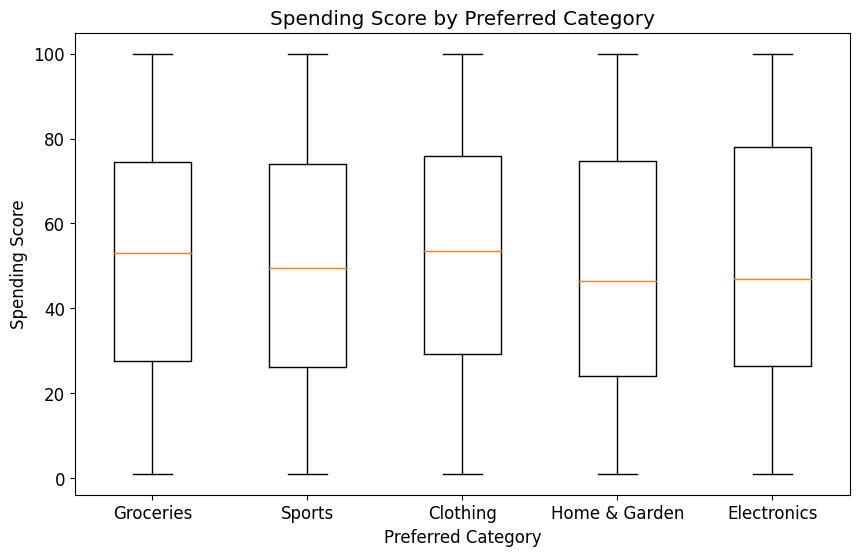

In [36]:
#Spending Score by Preferred Category

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['preferred_category'] == cat]['spending_score'] for cat in df['preferred_category'].unique()], labels=df['preferred_category'].unique())
plt.xlabel('Preferred Category')
plt.ylabel('Spending Score')
_ = plt.title('Spending Score by Preferred Category')

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

**Data Preprocessing**

In [5]:
# Convert object columns to categorical
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# Label Encoding for categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include=['category']):
    df[col] = le.fit_transform(df[col])

In [6]:
# Scale numerical columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

**K-Means Clustering:**

In [7]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)

# Assign cluster labels
df['cluster'] = kmeans.labels_

# Analyze clusters
print(df.groupby('cluster').mean())


               id       age    gender    income  spending_score  \
cluster                                                           
0       -0.500159 -0.132153  0.210292 -0.476665       -0.070132   
1        0.096177 -0.071324 -0.646815  0.107711        0.365013   
2        0.343232  0.342949  0.441779 -0.828186       -0.098485   
3        0.401189 -0.744082  0.105961  0.663821       -0.566402   
4       -0.439603  0.649257 -0.227735  0.804854        0.457625   

         membership_years  purchase_frequency  preferred_category  \
cluster                                                             
0                0.777886            0.330486           -0.515048   
1               -0.667606           -0.754623            0.018289   
2               -0.234383           -0.208307            0.136461   
3               -0.118308            0.519006            0.526115   
4                0.287615            0.152236           -0.195620   

         last_purchase_amount  
cluster       

**Visualization:**

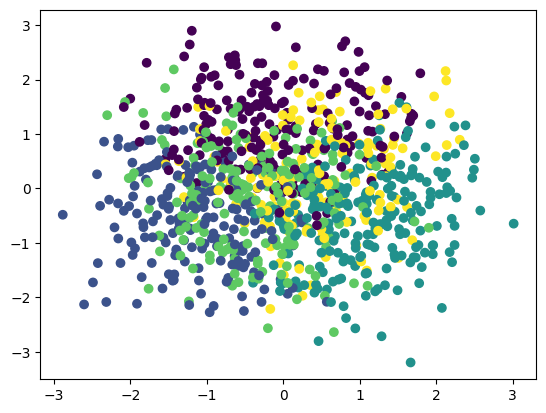

In [8]:
# Visualize clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.drop('cluster', axis=1))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['cluster'])
plt.show()

In [ ]:
# Calculate cluster statistics
cluster_stats = df.groupby('cluster').mean()

# Visualize cluster differences
import seaborn as sns
sns.pairplot(df, hue='cluster')
# Enable interactive zoom
plt.ion()
plt.show()



Output hidden; open in https://colab.research.google.com to view.

Identify **high-value customers** and prioritize marketing efforts
and **understand characteristics of each CLV segment(**e.g., purchase frequency, average order value)

In [12]:
#Calculate RFM scores
df['recency'] = df['membership_years'] - df['purchase_frequency']
df['rfm_score'] = df['purchase_frequency'] * df['last_purchase_amount']

<ipython-input-13-2505529da4a1>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('clv_segment')[numerical_cols].mean())


                             age  purchase_frequency  last_purchase_amount  \
clv_segment                                                                  
Low-Value Customers     0.034055            0.016085             -0.110047   
Medium-Value Customers -0.065216            0.028202              0.012915   
High-Value Customers    0.048189           -0.036245              0.042109   

                        membership_years       clv  
clv_segment                                         
Low-Value Customers            -0.097747 -1.341074  
Medium-Value Customers          0.009109 -0.103947  
High-Value Customers            0.039765  0.836633  


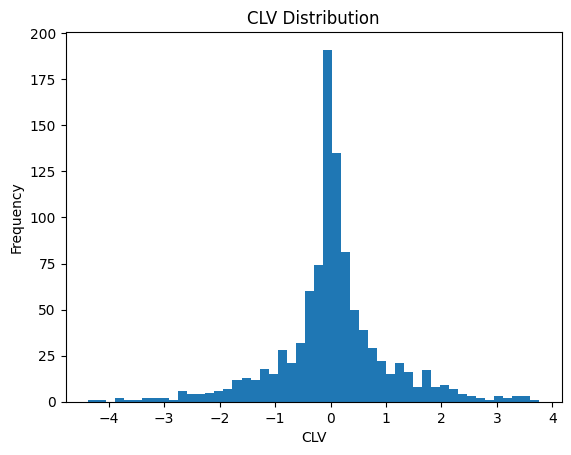

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


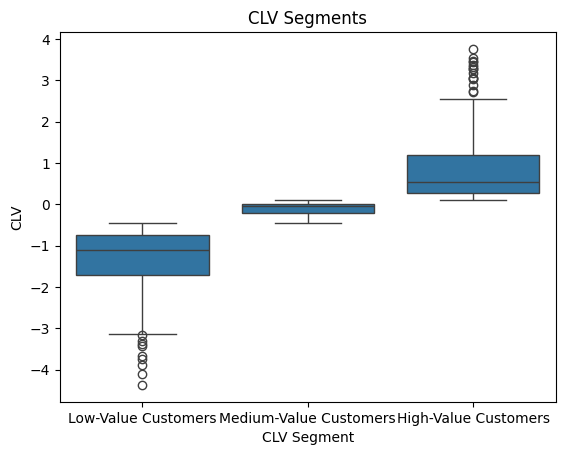

In [13]:
# Calculate CLV
df['clv'] = df['purchase_frequency'] * df['last_purchase_amount'] * df['membership_years']

# Segment customers based on CLV
clv_segments = pd.qcut(df['clv'], q=[0, 0.2, 0.6, 1], labels=['Low-Value Customers', 'Medium-Value Customers', 'High-Value Customers'])

# Assign CLV segments
df['clv_segment'] = clv_segments

# Analyze CLV segments (numerical columns only)
numerical_cols = ['age', 'purchase_frequency', 'last_purchase_amount', 'membership_years', 'clv']
print(df.groupby('clv_segment')[numerical_cols].mean())

# Visualize CLV distribution
import matplotlib.pyplot as plt
plt.hist(df['clv'], bins=50)
plt.title('CLV Distribution')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.show()

# Visualize CLV segments
import seaborn as sns
sns.boxplot(x='clv_segment', y='clv', data=df)
plt.title('CLV Segments')
plt.xlabel('CLV Segment')
plt.ylabel('CLV')
plt.show()

Assign **targeted marketing strategies to customer segments based on CLV.**
and visualize the distribution of marketing strategies across segments.
Inform marketing resource allocation and campaign optimization.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [15]:
# Segment customers
df['clv_segment'] = pd.qcut(df['clv'], q=[0, 0.2, 0.6, 1], labels=['Low-Value', 'Medium-Value', 'High-Value'])

In [16]:
# Define marketing strategies
def marketing_strategy(segment):
    if segment == 'Low-Value':
        return 'Re-engagement campaign'
    elif segment == 'Medium-Value':
        return 'Email nurturing campaign'
    elif segment == 'High-Value':
        return 'Loyalty program'
    else:
        return 'Win-back program'


In [17]:
# Apply marketing strategies
df['marketing_strategy'] = df['clv_segment'].apply(marketing_strategy)


In [27]:
import warnings
warnings.filterwarnings("ignore")

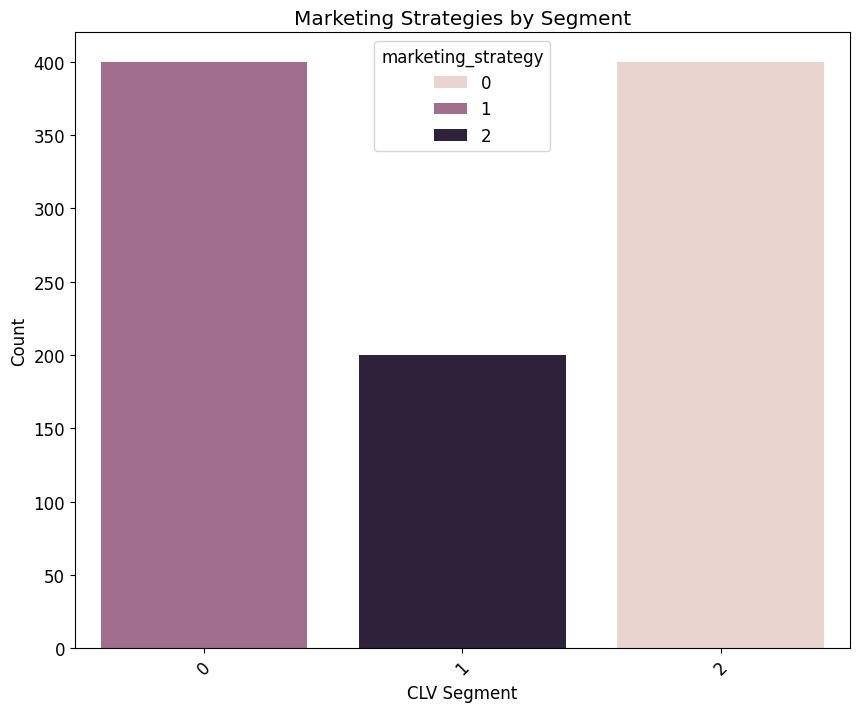

In [30]:
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Visualize marketing strategies
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})
sns.countplot(x='clv_segment', hue='marketing_strategy', data=df)
plt.title('Marketing Strategies by Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Predict the **most effective marketing strategy for each customer.**
Identify key customer characteristics influencing marketing strategy effectiveness.
Inform marketing resource allocation and campaign optimization.

In [ ]:
# Prepare data for modeling

for cols in df.columns:
  if df[cols].dtype == 'object':
    df[cols] = df[cols].astype('category')
    df[cols] = df[cols].cat.codes
X = df.drop(['clv_segment', 'marketing_strategy'], axis=1)
y = df['marketing_strategy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, class_weight='balanced')
rfc.fit(X_train_scaled, y_train)

y_pred = rfc.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.995
Classification Report:
                          precision    recall  f1-score   support

Email nurturing campaign       1.00      0.99      0.99        78
         Loyalty program       0.99      1.00      0.99        72
  Re-engagement campaign       1.00      1.00      1.00        50

                accuracy                           0.99       200
               macro avg       1.00      1.00      1.00       200
            weighted avg       1.00      0.99      1.00       200



 Propensity Scoring:


- **Predict likelihood of customers making a purchase in the next X days**
- Use machine learning models (e.g., logistic regression, decision trees)



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount,cluster,recency,rfm_score,clv,clv_segment,marketing_strategy
0,-1.730320,-0.384644,-1.260917,0.316868,1.358468,-0.865010,-0.182348,-0.051028,-1.281540,1,-0.682662,0.233686,-0.202141,Medium-Value,Email nurturing campaign
1,-1.726856,-1.515362,-1.260917,-0.282016,0.321865,-1.215358,1.082005,1.386386,-1.523763,1,-2.297364,-1.648719,2.003785,High-Value,Loyalty program
2,-1.723391,1.078639,-1.260917,1.112778,-0.714738,-1.215358,0.098620,-1.488442,-0.230005,4,-1.313978,-0.022683,0.027568,Medium-Value,Email nurturing campaign
3,-1.719927,-0.251618,1.233479,-1.210096,0.805613,1.237080,-1.516943,0.667679,1.690080,2,2.754023,-2.563754,-3.171569,Low-Value,Re-engagement campaign
4,-1.716463,1.411203,-1.260917,1.523374,-1.025718,-0.865010,-0.112106,-0.769735,-0.491443,4,-0.752904,0.055094,-0.047657,Medium-Value,Email nurturing campaign


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [23]:
# Define numerical and categorical columns
numerical_cols = ['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency',
                  'last_purchase_amount', 'recency', 'rfm_score', 'clv']
categorical_cols = ['gender', 'preferred_category', 'cluster', 'clv_segment', 'marketing_strategy']

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode categorical features
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [25]:
# Define target variable (e.g., 'next_purchase')
df['next_purchase'] = (df['last_purchase_amount'] > df['last_purchase_amount'].median()).astype(int)

# Split data into training and testing sets
X = df.drop('next_purchase', axis=1)
y = df['next_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
# Define target variable (e.g., 'next_purchase')
df['next_purchase'] = (df['last_purchase_amount'] > df['last_purchase_amount'].median()).astype(int)

# Split data into training and testing sets
X = df.drop('next_purchase', axis=1)
y = df['next_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate model performance
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[ 97   0]
 [  0 103]]
